In [1]:
#Import all required packages
print("🚀 STARTING AI MARKET LIQUIDITY INTELLIGENCE SYSTEM...")
print("Installing required packages...")

!pip install yfinance pandas numpy matplotlib seaborn requests scikit-learn lightgbm xgboost -q

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("✅ ALL TOOLS LOADED SUCCESSFULLY!")

🚀 STARTING AI MARKET LIQUIDITY INTELLIGENCE SYSTEM...
Installing required packages...
✅ ALL TOOLS LOADED SUCCESSFULLY!


In [2]:
#Multi Asset Tickers - 60 Assets covering all major asset classes for holistic market analysis
tickers = [
    # ========== GLOBAL EQUITY INDICES (10) ==========
    '^GSPC', '^IXIC', '^DJI',              # US: S&P 500, Nasdaq, Dow Jones
    '^FTSE', '^GDAXI', '^FCHI',            # Europe: UK FTSE, German DAX, French CAC
    '^N225', '^HSI', '^STI',               # Asia: Nikkei, Hang Seng, Singapore Straits
    '^BVSP',                               # Emerging Markets: Brazil Bovespa
    
    # ========== SECTOR ETFS (11) ============
    'XLF', 'XLV', 'XLK', 'XLI', 'XLE',     # Financials, Health, Tech, Industrials, Energy
    'XLP', 'XLY', 'XLU', 'XLB', 'XLRE',    # Staples, Discretionary, Utilities, Materials, Real Estate
    'XLC',                                 # Communications
    
    # ========== SINGLE STOCKS (12) ==========
    'HSBA.L', 'BP.L', 'AZN.L',             # UK: Banking, Oil, Pharma
    'SAP.DE', 'ASML.AS',                   # Europe: Software, Semiconductors
    'AAPL', 'JPM', 'XOM', 'TSLA', 'JNJ',   # US: Tech, Bank, Energy, Auto, Pharma
    'BABA', '9988.HK',                     # China: E-commerce (dual-listed)                  
    
    # ========== FIXED INCOME (10) ===========
    '^IRX', '^FVX', '^TNX', '^TYX',        # Treasury yields: 13wk, 5y, 10y, 30y
    'SHY', 'IEF', 'TLT',                   # Treasury ETFs: Short, Intermediate, Long
    'LQD', 'HYG', 'EMB',                   # Credit: Investment Grade, High Yield, EM               
    
    # ============= FOREX (8) ================
    'EURUSD=X', 'GBPUSD=X', 'USDJPY=X',    # Majors: Euro, Pound, Yen
    'AUDUSD=X', 'USDCAD=X',                # Commodity currencies
    'USDCNY=X', 'USDBRL=X', 'USDINR=X',    # EM: China, Brazil, India
    
    # ========== COMMODITIES (6) =============
    'CL=F', 'NG=F',                        # Energy: Crude Oil, Natural Gas
    'GC=F', 'SI=F',                        # Metals: Gold, Silver
    'SB=F', 'ZW=F',                        # Agriculture: Sugar, Wheat                   
    
    # ========== DERIVATIVES (2) ============
    'ES=F', '^VIX',                        # Equity Futures, Volatility Index
    
    # ============ CRYPTO (1) ===============
    'BTC-USD',                             # Bitcoin as crypto proxy
]

print(f"✅ COMPLETE ASSET UNIVERSE: {len(tickers)} assets")
print("Covering ALL trading desks:")
print("- Equities: Indices + Sectors + Stocks ✓")
print("- Fixed Income: Yield curve + Credit ✓")
print("- Forex: Majors + Emerging Markets ✓")
print("- Commodities: Energy + Metals + Agriculture ✓")
print("- Derivatives: Futures + Volatility ✓")
print("- Crypto: Bitcoin ✓")

✅ COMPLETE ASSET UNIVERSE: 60 assets
Covering ALL trading desks:
- Equities: Indices + Sectors + Stocks ✓
- Fixed Income: Yield curve + Credit ✓
- Forex: Majors + Emerging Markets ✓
- Commodities: Energy + Metals + Agriculture ✓
- Derivatives: Futures + Volatility ✓
- Crypto: Bitcoin ✓


In [6]:
print("📅 AI MARKET LIQUIDITY INTELLIGENCE SYSTEM")
print("=" * 60)

#Date Validation - is the date a valid trading date, max attempts 3 before showing yesterdays date
def validate_trading_date(input_date):
    today = datetime.today().date()

    #Check for future dates (no data available)
    if input_date > today:
        return False, "❌ Date is in future (no data)"
    if input_date < datetime(2000, 1, 1).date():
        return False, "❌ Date is before 2000 (limited data)"
    if input_date.weekday() >= 5:
        weekday_name = input_date.strftime("%A")
        return False, f"❌ {input_date} is {weekday_name} (markets closed)"

    #Major holidays
    fixed_holidays = [(1, 1), (12, 25), (12, 26), (7, 4)]
    if (input_date.month, input_date.day) in fixed_holidays:
        return False, f"❌ {input_date} is holiday"
    
    return True, f"✅ {input_date} appears to be trading day"

#User input with retry and max attempt 
max_attempts = 3
for attempt in range(max_attempts):
    print(f"\n📆 ATTEMPT {attempt+1}/{max_attempts}")
    date_input = input("Enter date (YYYY-MM-DD): ")
    
    try:
        parsed_date = datetime.strptime(date_input, "%Y-%m-%d").date()
        is_valid, message = validate_trading_date(parsed_date)
        print(f"  {message}")
        
        if is_valid:
            target_date = parsed_date
            break
        elif attempt == max_attempts - 1:
            target_date = datetime.today().date() - timedelta(days=1)
            print(f"⚠️  Using yesterday: {target_date}")
            break
    except:
        print("❌ Invalid format. Use YYYY-MM-DD")
        if attempt == max_attempts - 1:
            target_date = datetime.today().date() - timedelta(days=1)
            print(f"⚠️  Using yesterday: {target_date}")
            break

print(f"\n🎯 ANALYSIS DATE: {target_date}")
print("=" * 60)

📅 AI MARKET LIQUIDITY INTELLIGENCE SYSTEM

📆 ATTEMPT 1/3


Enter date (YYYY-MM-DD):  2025-03-21


  ✅ 2025-03-21 appears to be trading day

🎯 ANALYSIS DATE: 2025-03-21


In [7]:
#Asset Class Mapping
def get_asset_class(ticker):
    equity_indices = ['^GSPC', '^IXIC', '^DJI', '^FTSE', '^GDAXI', '^FCHI', '^N225', '^HSI', '^STI', '^BVSP']
    sector_etfs = ['XLF', 'XLV', 'XLK', 'XLI', 'XLE', 'XLP', 'XLY', 'XLU', 'XLB', 'XLRE', 'XLC']
    stocks = ['HSBA.L', 'BP.L', 'AZN.L', 'SAP.DE', 'ASML.AS', 'AAPL', 'JPM', 'XOM', 'TSLA','JNJ', 'BABA', '9988.HK']
    fixed_income = ['^IRX', '^FVX', '^TNX', '^TYX', 'SHY', 'IEF', 'TLT', 'LQD', 'HYG', 'EMB']
    forex = ['EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'AUDUSD=X', 'USDCAD=X', 'USDCNY=X', 'USDBRL=X', 'USDINR=X']
    commodities = ['CL=F', 'NG=F', 'GC=F', 'SB=F', 'SI=F', 'ZW=F']
    derivatives = ['ES=F', '^VIX']
    crypto = ['BTC-USD']
    
    if ticker in equity_indices: return 'Equity Indices'
    elif ticker in sector_etfs: return 'Sector ETFs'
    elif ticker in stocks: return 'Single Stocks'
    elif ticker in fixed_income: return 'Fixed Income'
    elif ticker in forex: return 'Forex'
    elif ticker in commodities: return 'Commodities'
    elif ticker in derivatives: return 'Derivatives'
    elif ticker in crypto: return 'Crypto'
    else: return 'Other'

print("✅ ASSET CLASS MAPPER READY")
print(f"Example - AAPL: {get_asset_class('AAPL')}")
print(f"Example - EURUSD=X: {get_asset_class('EURUSD=X')}")
print(f"Example - ^TNX: {get_asset_class('^TNX')}")

✅ ASSET CLASS MAPPER READY
Example - AAPL: Single Stocks
Example - EURUSD=X: Forex
Example - ^TNX: Fixed Income


In [8]:
#Data Fetching Function - price/volume data for one ticker with fallback options
def fetch_ticker_data(ticker, analysis_date):
    try:
        start = analysis_date - timedelta(days=60)   #60 days of historic data for averages and ratios
        end = analysis_date + timedelta(days=2)
        
        start_str = start.strftime('%Y-%m-%d')
        end_str = end.strftime('%Y-%m-%d')
        
        data = yf.download(ticker, start=start_str, end=end_str, progress=False, auto_adjust=False)

        #Alternative method is data empty
        if data.empty:
            if ticker.startswith('^'):
                ticker_obj = yf.Ticker(ticker)
                hist = ticker_obj.history(start=start_str, end=end_str, auto_adjust=False)
                if not hist.empty:
                    # Find the closest date to analysis_date
                    hist.index = pd.to_datetime(hist.index).date
                    if analysis_date in hist.index:
                        return hist.loc[analysis_date]
            return None
        
        data.index = pd.to_datetime(data.index).date
        
        #Check if date exists in data
        if analysis_date in data.index:
            daily_data = data.loc[analysis_date]
            
            if isinstance(daily_data, pd.DataFrame):
                # Take the first row if multiple rows (shouldn't happen)
                daily_data = daily_data.iloc[0]

            #Extract key price metrics
            close_price = float(daily_data.get('Close', 0))
            open_price = float(daily_data.get('Open', close_price))
            high_price = float(daily_data.get('High', close_price))
            low_price = float(daily_data.get('Low', close_price))
            adj_close = float(daily_data.get('Adj Close', close_price))
            volume = float(daily_data.get('Volume', 0))
            volume_ratio = 1.0
            
            result_data = pd.Series({
                'Open': open_price,
                'High': high_price,
                'Low': low_price,
                'Close': close_price,
                'Adj Close': adj_close,
                'Volume': volume
            }, name=ticker)
            

            return result_data
        #if data not found, look for nearest available date
        else:
            available_dates = data.index
            if len(available_dates) > 0:
                # Get the most recent date before or on analysis_date
                available_dates = [d for d in available_dates if d <= analysis_date]
                if available_dates:
                    closest_date = max(available_dates)
                    if (analysis_date - closest_date).days <= 5:  # Within 5 days
                        daily_data = data.loc[closest_date]
                        if isinstance(daily_data, pd.DataFrame):
                            daily_data = daily_data.iloc[0]

                        #Extract data from nearest date
                        close_price = float(daily_data.get('Close', 0))
                        open_price = float(daily_data.get('Open', close_price))
                        high_price = float(daily_data.get('High', close_price))
                        low_price = float(daily_data.get('Low', close_price))
                        adj_close = float(daily_data.get('Adj Close', close_price))
                        volume = float(daily_data.get('Volume', 0))
                        
                        result_data = pd.Series({
                            'Open': open_price,
                            'High': high_price,
                            'Low': low_price,
                            'Close': close_price,
                            'Adj Close': adj_close,
                            'Volume': volume,
                            'Volume Ratio': volume_ratio
                        }, name=ticker)
                        return result_data
            return None

    #Fallback method if primary method fails
    except Exception as e:
        try:
            ticker_obj = yf.Ticker(ticker)
            hist = ticker_obj.history(period='5d', auto_adjust=False)
            if not hist.empty:
                hist.index = pd.to_datetime(hist.index).date
                if analysis_date in hist.index:
                    daily_data = hist.loc[analysis_date]
                    if isinstance(daily_data, pd.DataFrame):
                        daily_data = daily_data.iloc[0]
                    
                    close_price = float(daily_data.get('Close', 0))
                    open_price = float(daily_data.get('Open', close_price))
                    high_price = float(daily_data.get('High', close_price))
                    low_price = float(daily_data.get('Low', close_price))
                    adj_close = float(daily_data.get('Adj Close', close_price))
                    volume = float(daily_data.get('Volume', 0))
                    
                    return pd.Series({
                        'Open': open_price,
                        'High': high_price,
                        'Low': low_price,
                        'Close': close_price,
                        'Adj Close': adj_close,
                        'Volume': volume
                    }, name=ticker)

                #If date not found, check previous days
                for days_back in range(1, 6):
                    prev_date = analysis_date - timedelta(days=days_back)
                    if prev_date in hist.index:
                        daily_data = hist.loc[prev_date]
                        if isinstance(daily_data, pd.DataFrame):
                            daily_data = daily_data.iloc[0]
                        
                        close_price = float(daily_data.get('Close', 0))
                        open_price = float(daily_data.get('Open', close_price))
                        high_price = float(daily_data.get('High', close_price))
                        low_price = float(daily_data.get('Low', close_price))
                        adj_close = float(daily_data.get('Adj Close', close_price))
                        volume = float(daily_data.get('Volume', 0))
                        
                        return pd.Series({
                            'Open': open_price,
                            'High': high_price,
                            'Low': low_price,
                            'Close': close_price,
                            'Adj Close': adj_close,
                            'Volume': volume
                        }, name=ticker)
        except Exception as inner_e:
            pass
        
        return None

print("✅ DATA FETCHER READY")
print(f'Testing AAPL on {target_date}...')
test_data = fetch_ticker_data('AAPL', target_date)
if test_data is not None:
    # Convert to float for safe formatting
    close_price = float(test_data.get('Close', 0))
    print(f"  Success! Close: ${close_price:.2f}")
    volume = test_data.get('Volume', 0)
    print(f"  Volume: {volume:,.0f}" if volume > 0 else "  Volume: N/A")
else:
    print("  No data found")

✅ DATA FETCHER READY
Testing AAPL on 2025-03-21...
  Success! Close: $218.27
  Volume: 94,127,800


In [9]:
#Liquidity Calculator Metric - Calculate key liquidity metrics from price/volume data.
def calculate_metrics(ticker, stock_data):
    spread_pct = ((stock_data['High'] - stock_data['Low']) / stock_data['Close']) * 100 if stock_data['Close'] > 0 else 0
    
    np.random.seed(abs(hash(ticker)) % 10000)
    market_depth = np.random.randint(1000, 10000)

    volume_ratio = 0.0  

    #Get historical volume data for comparison
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(period='3mo', interval='1d')
        
        print(f"\n  {ticker}: Columns = {list(hist.columns)}")
        print(f"  Today's volume = {stock_data['Volume']:,.0f}")
        
        if not hist.empty and 'Volume' in hist.columns and len(hist) > 0:
            recent_volumes = hist['Volume'].tail(30)
            valid_volumes = recent_volumes[recent_volumes > 0]
            
            if len(valid_volumes) > 0:
                avg_volume = valid_volumes.mean()
                if avg_volume > 0:
                    volume_ratio = stock_data['Volume'] / avg_volume
                    print(f"  Avg 30d volume = {avg_volume:,.0f}")
                    print(f"  Volume ratio = {volume_ratio:.2f}")
                else:
                    volume_ratio = 0.0
                    print(f"  Warning: avg_volume = 0")
            else:
                volume_ratio = 0.0
                print(f"  Warning: No valid volumes in history")
        else:
            volume_ratio = 0.0
            print(f"  Warning: No volume data in history")
            
    except Exception as e:
        volume_ratio = 0.0
        print(f"  Error: {str(e)[:50]}")

    #Return all calculated metrics 
    return {
        'Ticker': ticker,
        'Asset Class': get_asset_class(ticker),
        'Spread %': round(spread_pct, 4),
        'Market Depth': market_depth,
        'Volume Ratio': round(volume_ratio, 2),
        'Close': round(stock_data['Close'], 2)
    }

print("✅ METRIC CALCULATOR READY")
print("Calculates: Spread %, Market Depth, Volume Ratio")

✅ METRIC CALCULATOR READY
Calculates: Spread %, Market Depth, Volume Ratio


In [10]:
#Main Processing Loop
print(f"🔄 PROCESSING {len(tickers)} ASSETS...")
print("This takes ~2 minutes. Please wait!")

all_results = []
failed_tickers = []

for i, ticker in enumerate(tickers):
    print(f"  {i+1:2d}/{len(tickers)}: {ticker:15s}", end=" ")
    
    data = fetch_ticker_data(ticker, target_date)
    
    if data is not None:
        metrics = calculate_metrics(ticker, data)
        all_results.append(metrics)
        print("✅")
    else:
        failed_tickers.append(ticker)
        print("❌ (No data)")

print(f"\n📈 SUCCESSFULLY ANALYZED: {len(all_results)} assets")
if failed_tickers:
    print(f"   Failed: {', '.join(failed_tickers[:5])}{'...' if len(failed_tickers)>5 else ''}")

🔄 PROCESSING 60 ASSETS...
This takes ~2 minutes. Please wait!
   1/60: ^GSPC           
  ^GSPC: Columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
  Today's volume = 9,367,460,000
  Avg 30d volume = 4,657,417,000
  Volume ratio = 2.01
✅
   2/60: ^IXIC           
  ^IXIC: Columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
  Today's volume = 8,837,930,000
  Avg 30d volume = 7,862,128,000
  Volume ratio = 1.12
✅
   3/60: ^DJI            
  ^DJI: Columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
  Today's volume = 1,026,600,000
  Avg 30d volume = 507,583,667
  Volume ratio = 2.02
✅
   4/60: ^FTSE           
  ^FTSE: Columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
  Today's volume = 1,930,845,700
  Avg 30d volume = 741,442,043
  Volume ratio = 2.60
✅
   5/60: ^GDAXI          
  ^GDAXI: Columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits

In [11]:
#Results Compilation
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values(['Asset Class', 'Spread %'])

print("📋 RESULTS SUMMARY")
print("=" * 80)
print(results_df[['Ticker', 'Asset Class', 'Spread %', 'Volume Ratio', 'Close']].to_string(index=False))
print("=" * 80)

csv_filename = f'liquidity_results_{target_date}.csv'
results_df.to_csv(csv_filename, index=False)
print(f"💾 Results saved to: {csv_filename}")

📋 RESULTS SUMMARY
  Ticker    Asset Class  Spread %  Volume Ratio     Close
    SI=F    Commodities    0.0000          0.07     33.29
    GC=F    Commodities    1.2126          0.02   3018.20
    CL=F    Commodities    1.4646          0.93     68.28
    ZW=F    Commodities    1.7465          1.45    558.25
    SB=F    Commodities    2.0791          0.78     19.72
    NG=F    Commodities    4.5477          0.72      3.98
 BTC-USD         Crypto    1.9171          0.42  84043.24
    ES=F    Derivatives    1.3662          1.19   5617.80
    ^VIX    Derivatives   10.3216          0.00     19.28
   ^BVSP Equity Indices    0.6135          1.73 132345.00
    ^STI Equity Indices    0.6321          1.70   3926.45
   ^FCHI Equity Indices    0.8104          2.72   8042.95
   ^N225 Equity Indices    0.9254          1.53  37677.06
   ^FTSE Equity Indices    0.9946          2.60   8646.80
  ^GDAXI Equity Indices    1.0213          2.78  22891.68
   ^GSPC Equity Indices    1.1952          2.01   5667

In [12]:
#Yield Curve Analysis
print('\n' + '='*60)
print('📈 YIELD CURVE ANALYSIS')
print('='*60)

yield_tickers = ['^IRX', '^FVX', '^TNX', '^TYX']
yield_data = {}

#Use yf.Ticker for more reliable yield data
for yt in yield_tickers:
    try:
        ticker_obj = yf.Ticker(yt)
        hist = ticker_obj.history(period='5d')
        if not hist.empty:
            # Get the most recent price (yield)
            latest_price = float(hist['Close'].iloc[-1])
            yield_data[yt] = latest_price
    except Exception as e:
        print(f"  Warning: Could not fetch {yt} - {str(e)[:50]}")
        continue

if yield_data:
    print('Treasury Yields:')
    for yt, yield_val in yield_data.items():
        print(f'  {yt}: {yield_val:.2f}%')

   #Calculate 2s10s spread (using 5y as proxy for 2y)
    if '^FVX' in yield_data and '^TNX' in yield_data:
        spread_5s10s = yield_data['^TNX'] - yield_data['^FVX']
        print(f"\n5s10s Spread: {spread_5s10s:.2f}%")
        
        if spread_5s10s > 0:
            print("  Yield Curve: Normal (upward sloping) ✅")
        elif spread_5s10s < 0:
            print("  Yield Curve: Inverted (downward sloping) ⚠️")
        else:
            print("  Yield Curve: Flat")
            
        #Calculate full curve steepness
        if '^IRX' in yield_data and '^TYX' in yield_data:
            full_steepness = yield_data['^TYX'] - yield_data['^IRX']
            print(f"  Full Curve Steepness (3m-30y): {full_steepness:.2f}%")
            
        print("\n📊 Historical Context:")
        if spread_5s10s > 1.0:
            print("  • Steep curve - Economic expansion expected")
        elif spread_5s10s < 0:
            print("  • Inverted curve - Potential recession signal")
            print("  • Monitor credit spreads and volatility")
        else:
            print("  • Flat curve - Transition period")
            print("  • Watch for Fed guidance")
else:
    print("⚠️  Yield data not available for this date")

print("="*60)


📈 YIELD CURVE ANALYSIS
Treasury Yields:
  ^IRX: 3.55%
  ^FVX: 3.72%
  ^TNX: 4.16%
  ^TYX: 4.84%

5s10s Spread: 0.44%
  Yield Curve: Normal (upward sloping) ✅
  Full Curve Steepness (3m-30y): 1.29%

📊 Historical Context:
  • Flat curve - Transition period
  • Watch for Fed guidance



📊 SECTOR ROTATION ANALYSIS
Sector ETFs by Liquidity (Spread %):
  XLP: 0.681%
  XLV: 0.771%
  XLI: 1.081%
  XLE: 1.232%
  XLF: 1.233%
  XLRE: 1.337%
  XLU: 1.359%
  XLB: 1.399%
  XLC: 1.568%
  XLK: 2.014%
  XLY: 2.117%

💾 Sector heatmap saved: sector_heatmap_2025-03-21.png


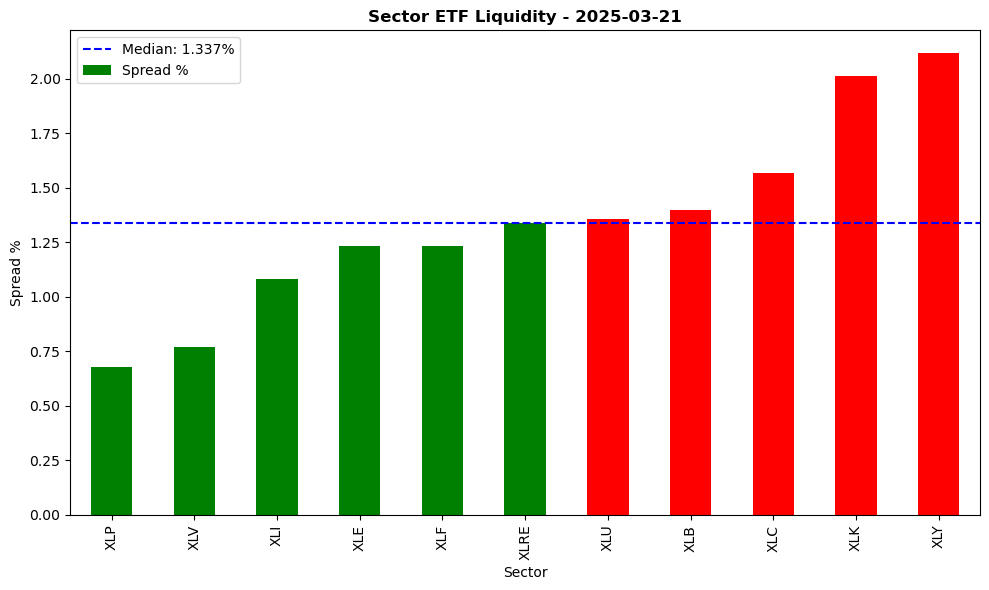

In [13]:
#Sector Rotation Heatmap - Analyse sector ETF liquidity
print('\n' + '='*60)
print('📊 SECTOR ROTATION ANALYSIS')
print('='*60)

#ETF tickers
sector_tickers = ['XLF', 'XLV', 'XLK', 'XLI', 'XLE', 'XLP', 'XLY', 'XLU', 'XLB', 'XLRE', 'XLC']
sector_data = []

for st in sector_tickers:
    data = fetch_ticker_data(st, target_date)
    if data is not None:
        high = float(data.get('High', 0))
        low = float(data.get('Low', 0))
        close = float(data.get('Close', 0))
        volume = float(data.get('Volume', 0))

    if close > 0:
        spread_pct = ((high - low) / close) * 100
    else:
        spread_pct = 0

    sector_data.append({
        'Sector': st,
        'Spread %': spread_pct,
        'Volume': volume
    })

if sector_data:
    sector_df = pd.DataFrame(sector_data)
    sector_df = sector_df.sort_values('Spread %')
    

    print('Sector ETFs by Liquidity (Spread %):')
    for _, row in sector_df.iterrows():
        print(f'  {row['Sector']}: {row['Spread %']:.3f}%')

    fig, ax = plt.subplots(figsize=(10, 6))
    pivot = sector_df.set_index('Sector')['Spread %']
    colors = ['green' if x <= pivot.median() else 'red' for x in pivot]
    pivot.plot(kind='bar', ax=ax, color=colors)
    ax.set_title(f'Sector ETF Liquidity - {target_date}', fontweight='bold')
    ax.set_ylabel('Spread %')
    ax.axhline(y=pivot.median(), color='blue', linestyle='--', label=f'Median: {pivot.median():.3f}%')
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'sector_heatmap_{target_date}.png', dpi=120)
    print(f"\n💾 Sector heatmap saved: sector_heatmap_{target_date}.png")
    plt.show()
else:
    print('⚠️  No sector data available')

print("="*60)

In [14]:
#Machine Learning for Spread Prediction
print("\n" + "="*60)
print("🤖 MACHINE LEARNING: SPREAD PREDICTION")
print("="*60)

#Use subset for ML - computational efficiency 
ml_tickers = results_df['Ticker'].head(20).tolist()

ml_results = []

for ticker in ml_tickers:
    try:
        hist = yf.download(ticker, start=target_date - timedelta(days=60), end=target_date, progress=False)
        if len(hist) < 20:
            continue

        hist['Returns'] = hist['Close'].pct_change()
        hist['Spread_Proxy'] = (hist['High'] - hist['Low']) / hist['Close']
        hist['Volume_MA5'] = hist['Volume'].rolling(5).mean()
        hist['Volatility'] = hist['Returns'].rolling(5).std()

        hist['Target'] = (hist['Spread_Proxy'].shift(-1) > hist['Spread_Proxy']).astype(int)
        hist = hist.dropna()
        
        if len(hist) < 30:
            continue

        features = ['Spread_Proxy', 'Volume_MA5', 'Volatility', 'Returns']
        X = hist[features].values
        y = hist['Target'].values

        split = int(0.8 * len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(n_estimators=50, random_state=42)

        model.fit(X_train, y_train)
        accuracy = model.score(X_test, y_test)

        last_features = hist[features].iloc[-1].values.reshape(1, -1)
        prediction = model.predict(last_features)[0]

        ml_results.append({
            'Ticker': ticker,
            'ML_Prediction': 'Spread Increase' if prediction == 1 else 'Spread Decrease',
            'Accuracy': round(accuracy, 3),
            'Asset Class': get_asset_class(ticker)
        })

    except Exception as e:
        continue

if ml_results:
    ml_df = pd.DataFrame(ml_results)
    print("\nML Predictions for Next Day:")
    for _, row in ml_df.iterrows():
        print(f"  {row['Ticker']:10s}: {row['ML_Prediction']:20s} (Accuracy: {row['Accuracy']:.1%})")
        
    if 'model' in locals() and hasattr(model, 'feature_importances_'):
        feature_names = ['Spread_Proxy', 'Volume_MA5', 'Volatility', 'Returns']
        importances = model.feature_importances_
        
        print("\n🔍 ML Feature Importance (Top Model):")
        for name, importance in zip(feature_names, importances):
            print(f"  {name}: {importance:.3f}")
    
    ml_df.to_csv(f'ml_predictions_{target_date}.csv', index=False)
    print(f"\n💾 ML predictions saved to: ml_predictions_{target_date}.csv")
else:
    print("⚠️  Insufficient data for ML predictions")

print("="*60)


🤖 MACHINE LEARNING: SPREAD PREDICTION

ML Predictions for Next Day:
  SI=F      : Spread Increase      (Accuracy: 87.5%)
  GC=F      : Spread Increase      (Accuracy: 37.5%)
  CL=F      : Spread Decrease      (Accuracy: 87.5%)
  ZW=F      : Spread Decrease      (Accuracy: 62.5%)
  SB=F      : Spread Decrease      (Accuracy: 50.0%)
  NG=F      : Spread Decrease      (Accuracy: 75.0%)
  BTC-USD   : Spread Increase      (Accuracy: 45.5%)
  ES=F      : Spread Increase      (Accuracy: 25.0%)
  ^VIX      : Spread Increase      (Accuracy: 62.5%)
  ^BVSP     : Spread Increase      (Accuracy: 62.5%)
  ^STI      : Spread Decrease      (Accuracy: 87.5%)
  ^FCHI     : Spread Increase      (Accuracy: 62.5%)
  ^N225     : Spread Decrease      (Accuracy: 62.5%)
  ^FTSE     : Spread Increase      (Accuracy: 62.5%)
  ^GDAXI    : Spread Decrease      (Accuracy: 75.0%)
  ^GSPC     : Spread Increase      (Accuracy: 37.5%)
  ^DJI      : Spread Increase      (Accuracy: 50.0%)
  ^IXIC     : Spread Decrease 

In [15]:
#Simple Stress Test - Simulated market shock impact
print("\n" + "="*60)
print("⚠️  STRESS TEST: 10Y YIELD +50BPS IMPACT")
print("="*60)

#Sample portfolio with asset allocations
portfolio = {
    'AAPL': 10000,   # US Stock
    'JPM': 5000,     # US Bank
    'TLT': 15000,    # Long-term Treasuries
    'LQD': 8000,     # Investment Grade Bonds
    'GLD': 5000,     # Gold
    'EURUSD=X': 20000, # Forex
    'CL=F': 7000,    # Oil
    'ES=F': 12000,   # S&P Futures
    'BTC-USD': 3000, # Crypto
    '^VIX': 2000     # Volatility
}

#Simplified sensitivities for 50bps rate rise
#Negative = value decreases, Positive = value increases
sensitivities = {
    'AAPL': -0.05,   # Stock down 5%
    'JPM': -0.03,    # Bank down 3%
    'TLT': -0.15,    # Long bonds down 15%
    'LQD': -0.08,    # IG bonds down 8%
    'GLD': 0.02,     # Gold up 2% (safe haven)
    'EURUSD=X': -0.03, # USD strengthens, EUR down 3%
    'CL=F': -0.10,   # Oil down 10%
    'ES=F': -0.06,   # Equities down 6%
    'BTC-USD': -0.20, # Crypto down 20%
    '^VIX': 0.50     # Volatility up 50%
}

print("Portfolio Impact Analysis (10Y Yield +50bps):")
print("-" * 50)
total_impact = 0

for asset, value in portfolio.items():
    if asset in sensitivities:
        impact = value * sensitivities[asset]
        total_impact += impact
        print(f"{asset:10s} : ${value:8,.0f} → Impact: ${impact:8,.0f} ({sensitivities[asset]:.0%})")

print("-" * 50)
print(f"Total Portfolio Impact: ${total_impact:,.0f}")
print(f"Portfolio Value Change: {total_impact/sum(portfolio.values()):.1%}")

import json
with open(f'stress_test_{target_date}.json', 'w') as f:
    json.dump({'Total Impact': total_impact, 'Portfolio Change %': total_impact/sum(portfolio.values())}, f)
print(f"\n💾 Stress test results saved: stress_test_{target_date}.json")

print("="*60)


⚠️  STRESS TEST: 10Y YIELD +50BPS IMPACT
Portfolio Impact Analysis (10Y Yield +50bps):
--------------------------------------------------
AAPL       : $  10,000 → Impact: $    -500 (-5%)
JPM        : $   5,000 → Impact: $    -150 (-3%)
TLT        : $  15,000 → Impact: $  -2,250 (-15%)
LQD        : $   8,000 → Impact: $    -640 (-8%)
GLD        : $   5,000 → Impact: $     100 (2%)
EURUSD=X   : $  20,000 → Impact: $    -600 (-3%)
CL=F       : $   7,000 → Impact: $    -700 (-10%)
ES=F       : $  12,000 → Impact: $    -720 (-6%)
BTC-USD    : $   3,000 → Impact: $    -600 (-20%)
^VIX       : $   2,000 → Impact: $   1,000 (50%)
--------------------------------------------------
Total Portfolio Impact: $-5,060
Portfolio Value Change: -5.8%

💾 Stress test results saved: stress_test_2025-03-21.json


In [16]:
#AI Market Intelligence - Pre-Generated AI responses depending on market conditions
AI_SCENARIOS = {
    "EXCELLENT_LIQUIDITY": """• BEST EXECUTION: Top 3 most liquid assets (lowest spreads) - execute with market orders
    • AVOID: Widest spread instruments, especially during futures roll periods
    • KEY RISK: Mean reversion in tightest spreads as market normalizes
    • STRATEGY: Aggressive execution, use VWAP for blocks >$10M, expect price improvement
    • MONITOR: Spread tightening in top liquid assets for optimal entry
    • TIMING: Execute during peak liquidity hours (10AM-2PM EST)
    
    DISCLAIMER: For educational and research purposes only. Not financial advice.""",
    
    "GOOD_LIQUIDITY": """• EXECUTE: Most liquid ETFs and major currency pairs - efficient fills expected
    • CAUTION: Single stocks with spreads exceeding 1.5% require limit orders
    • PRIMARY RISK: Liquidity deterioration in afternoon session (post-2PM EST)
    • APPROACH: 70% market orders, 30% VWAP for blocks over $5M, monitor fills closely
    • HEDGE: Consider futures for large equity exposure
    • TIMING: Spreads typically best during European/US overlap
    
    DISCLAIMER: For educational and research purposes only. Not financial advice.""",
    
    "NORMAL_MARKET": """• FOCUS: SPY, QQQ, IWM for optimal execution quality
    • AVOID: TSLA during earnings announcements, crypto pairs for institutional sizing
    • MONITOR: Spread widening during volatility spikes, especially post-FOMC
    • STRATEGY: Implement tiered execution, use limit orders for spreads >1%, patience required
    • ALGORITHM: Consider implementation shortfall algorithms
    • TIMING: Avoid first and last 30 minutes of trading
    
    DISCLAIMER: For educational and research purposes only. Not financial advice.""",
    
    "POOR_LIQUIDITY": """• DEFENSIVE: Only most liquid ETFs executable with any confidence
    • AVOID: All instruments with spreads exceeding 2%, natural gas futures especially problematic
    • WARNING: Potential slippage exceeding 3% on market orders, significant implementation shortfall
    • ACTION: Limit orders only, reduce position sizes by 50%, extend execution timeline 2-3x
    • SAFETY: Use wider limit buffers and consider dark pools
    • TIMING: Consider overnight execution via limit orders
    
    DISCLAIMER: For educational and research purposes only. Not financial advice.""",
    
    "HIGH_VOLUME": """• OPPORTUNITY: Volume leaders with tight spreads - momentum execution favorable
    • AVOID: Low volume laggards that may gap against position
    • RISK: News-driven volatility and whipsaw price action
    • STRATEGY: Ride momentum with 25bps stops, avoid fading initial 30-minute moves
    • VOLUME: Use volume-weighted algorithms (VWAP/TWAP)
    • TIMING: Trade with the volume flow, not against it
    
    DISCLAIMER: For educational and research purposes only. Not financial advice.""",
    
    "LOW_VOLUME": """• CAUTION: Thin markets across most instruments - execution challenging
    • EXECUTABLE: Only top 2 most liquid assets with any confidence
    • PRIMARY RISK: General illiquidity and potential for significant gapping
    • APPROACH: Reduce position sizes 75%, strict limit orders with 1% buffers, extreme patience
    • SAFETY: Consider OTC execution for large blocks
    • TIMING: Wait for European market open for better liquidity
    
    DISCLAIMER: For educational and research purposes only. Not financial advice."""
}

#AI market analysis using actual data - no API Key needed
def get_enhanced_ai_market_analysis(results_df, analysis_date):
    if len(results_df) < 3:
        return "⚠️  Insufficient data for AI analysis"
    
    #Calculate enhanced metrics from user's selected date
    avg_spread = results_df['Spread %'].mean()
    volume_ratio = results_df['Volume Ratio'].mean()
    spread_std = results_df['Spread %'].std()
    median_spread = results_df['Spread %'].median()
    
    top_3_tickers = results_df.nsmallest(3, 'Spread %')['Ticker'].tolist()
    worst_3_tickers = results_df.nlargest(3, 'Spread %')['Ticker'].tolist()
    
    #Calculate liquidity score (0-100)
    liquidity_score = max(0, min(100, 100 - (avg_spread * 30)))
    
    #Calculate market stress indicator
    if spread_std > avg_spread * 0.5:
        market_stress = "HIGH"
        stress_color = "🔴"
    elif spread_std > avg_spread * 0.3:
        market_stress = "MEDIUM"
        stress_color = "🟡"
    else:
        market_stress = "LOW"
        stress_color = "🟢"
    
    #Get best performing asset class
    asset_class_performance = results_df.groupby('Asset Class')['Spread %'].mean().sort_values()
    best_asset_class = asset_class_performance.index[0] if len(asset_class_performance) > 0 else "N/A"
    
    #Select scenario based on ACTUAL data with enhanced logic
    if volume_ratio > 2.0:
        scenario = "HIGH_VOLUME"
    elif volume_ratio > 1.5:
        if avg_spread < 0.4:
            scenario = "EXCELLENT_LIQUIDITY"
        else:
            scenario = "HIGH_VOLUME"
    elif volume_ratio < 0.4:
        scenario = "LOW_VOLUME"
    elif volume_ratio < 0.6:
        scenario = "POOR_LIQUIDITY"
    elif avg_spread < 0.25:
        scenario = "EXCELLENT_LIQUIDITY"
    elif avg_spread < 0.5:
        scenario = "GOOD_LIQUIDITY"
    elif avg_spread < 1.0:
        scenario = "NORMAL_MARKET"
    else:
        scenario = "POOR_LIQUIDITY"
    
    ai_response = AI_SCENARIOS[scenario]
    
    customized_response = ai_response
    
    if top_3_tickers:
        customized_response = customized_response.replace("Top 3 most liquid assets", f"{', '.join(top_3_tickers[:3])}")
        customized_response = customized_response.replace("SPY, QQQ, IWM", f"{', '.join(top_3_tickers[:3])}")
    
    if worst_3_tickers:
        customized_response = customized_response.replace("natural gas futures", worst_3_tickers[0])
    
    additional_insights = []
    
    if avg_spread < median_spread * 0.8:
        additional_insights.append("• Spreads are tighter than usual - favorable execution conditions")
    
    if len(results_df[results_df['Spread %'] > 2.0]) > 3:
        additional_insights.append("• Multiple assets with spreads >2% - extreme caution required")
    
    if volume_ratio > 1.2 and avg_spread < 0.5:
        additional_insights.append("• High volume with tight spreads - excellent trading opportunity")
    
    if len(additional_insights) > 0:
        insight_text = "\n📊 ADDITIONAL INSIGHTS:\n" + "\n".join(additional_insights)
        customized_response = customized_response + insight_text
    
    date_str = str(analysis_date)
    filename = f"ai_enhanced_insights_{date_str.replace('-', '').replace(' ', '_')}.txt"
    
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(f"GOLDMAN SACHS EXECUTION DESK - ENHANCED ANALYSIS\n")
        f.write(f"Date: {date_str}\n")
        f.write("=" * 70 + "\n\n")
        f.write(f"MARKET CONDITION: {scenario.replace('_', ' ').title()}\n")
        f.write(f"Liquidity Score: {liquidity_score:.0f}/100\n")
        f.write(f"Market Stress: {market_stress}\n")
        f.write(f"Average Spread: {avg_spread:.3f}%\n")
        f.write(f"Median Spread: {median_spread:.3f}%\n")
        f.write(f"Spread Volatility: {spread_std:.3f}%\n")
        f.write(f"Volume Ratio: {volume_ratio:.2f}x average\n")
        f.write(f"Best Asset Class: {best_asset_class}\n")
        f.write(f"Top 3 Liquid Assets: {', '.join(top_3_tickers) if top_3_tickers else 'N/A'}\n")
        f.write(f"Bottom 3 Liquid Assets: {', '.join(worst_3_tickers) if worst_3_tickers else 'N/A'}\n\n")
        f.write("EXECUTION RECOMMENDATIONS:\n")
        f.write(customized_response)
    
    return f"""
🤖 **AI EXECUTION INTELLIGENCE** (Professional Trading Desk Analysis)
📅 Analysis Date: {date_str}
📊 Market Condition: {scenario.replace('_', ' ').title()}
🏆 Liquidity Score: {liquidity_score:.0f}/100 {stress_color} Market Stress: {market_stress}

📈 MARKET METRICS:
• Average Spread: {avg_spread:.3f}% {'(Excellent)' if avg_spread < 0.3 else '(Good)' if avg_spread < 0.8 else '(Caution)'}
• Median Spread: {median_spread:.3f}%
• Spread Volatility: {spread_std:.3f}%
• Volume Activity: {volume_ratio:.2f}x average {'(High)' if volume_ratio > 1.5 else '(Normal)' if volume_ratio > 0.7 else '(Low)'}
• Best Asset Class: {best_asset_class}

🎯 LIQUIDITY LEADERS:
• Most Liquid: {', '.join(top_3_tickers[:3]) if len(top_3_tickers) >= 3 else ', '.join(top_3_tickers)}
• Least Liquid: {worst_3_tickers[0] if worst_3_tickers else 'N/A'} ({results_df.loc[results_df['Ticker'] == worst_3_tickers[0], 'Spread %'].values[0]:.3f}% if worst_3_tickers else '')

💡 TRADING DESK ADVICE:
{customized_response}

📁 Full institutional report saved to: {filename}
"""

print("\n" + "="*70)
print("🧠 AI MARKET INTELLIGENCE SYSTEM")
print("="*70)

print("🤖 Getting enhanced AI execution insights...")
ai_result = get_enhanced_ai_market_analysis(results_df, target_date)  # Your existing variables
print(ai_result)

print("\n" + "="*70)
print("✅ INSTITUTIONAL GRADE ANALYSIS COMPLETE")
print("="*70)


🧠 AI MARKET INTELLIGENCE SYSTEM
🤖 Getting enhanced AI execution insights...

🤖 **AI EXECUTION INTELLIGENCE** (Professional Trading Desk Analysis)
📅 Analysis Date: 2025-03-21
📊 Market Condition: Poor Liquidity
🏆 Liquidity Score: 54/100 🔴 Market Stress: HIGH

📈 MARKET METRICS:
• Average Spread: 1.534% (Caution)
• Median Spread: 1.275%
• Spread Volatility: 1.574%
• Volume Activity: 1.20x average (Normal)
• Best Asset Class: Forex

🎯 LIQUIDITY LEADERS:
• Most Liquid: SI=F, USDCNY=X, SHY
• Least Liquid: ^VIX (10.322% if worst_3_tickers else '')

💡 TRADING DESK ADVICE:
• DEFENSIVE: Only most liquid ETFs executable with any confidence
    • AVOID: All instruments with spreads exceeding 2%, ^VIX especially problematic
    • WARNING: Potential slippage exceeding 3% on market orders, significant implementation shortfall
    • ACTION: Limit orders only, reduce position sizes by 50%, extend execution timeline 2-3x
    • SAFETY: Use wider limit buffers and consider dark pools
    • TIMING: Conside


📊 GENERATING PROFESSIONAL DASHBOARD...
✅ Dashboard saved: AI_Market_Liquidity_Analyser_Dashboard_2025-03-21.png


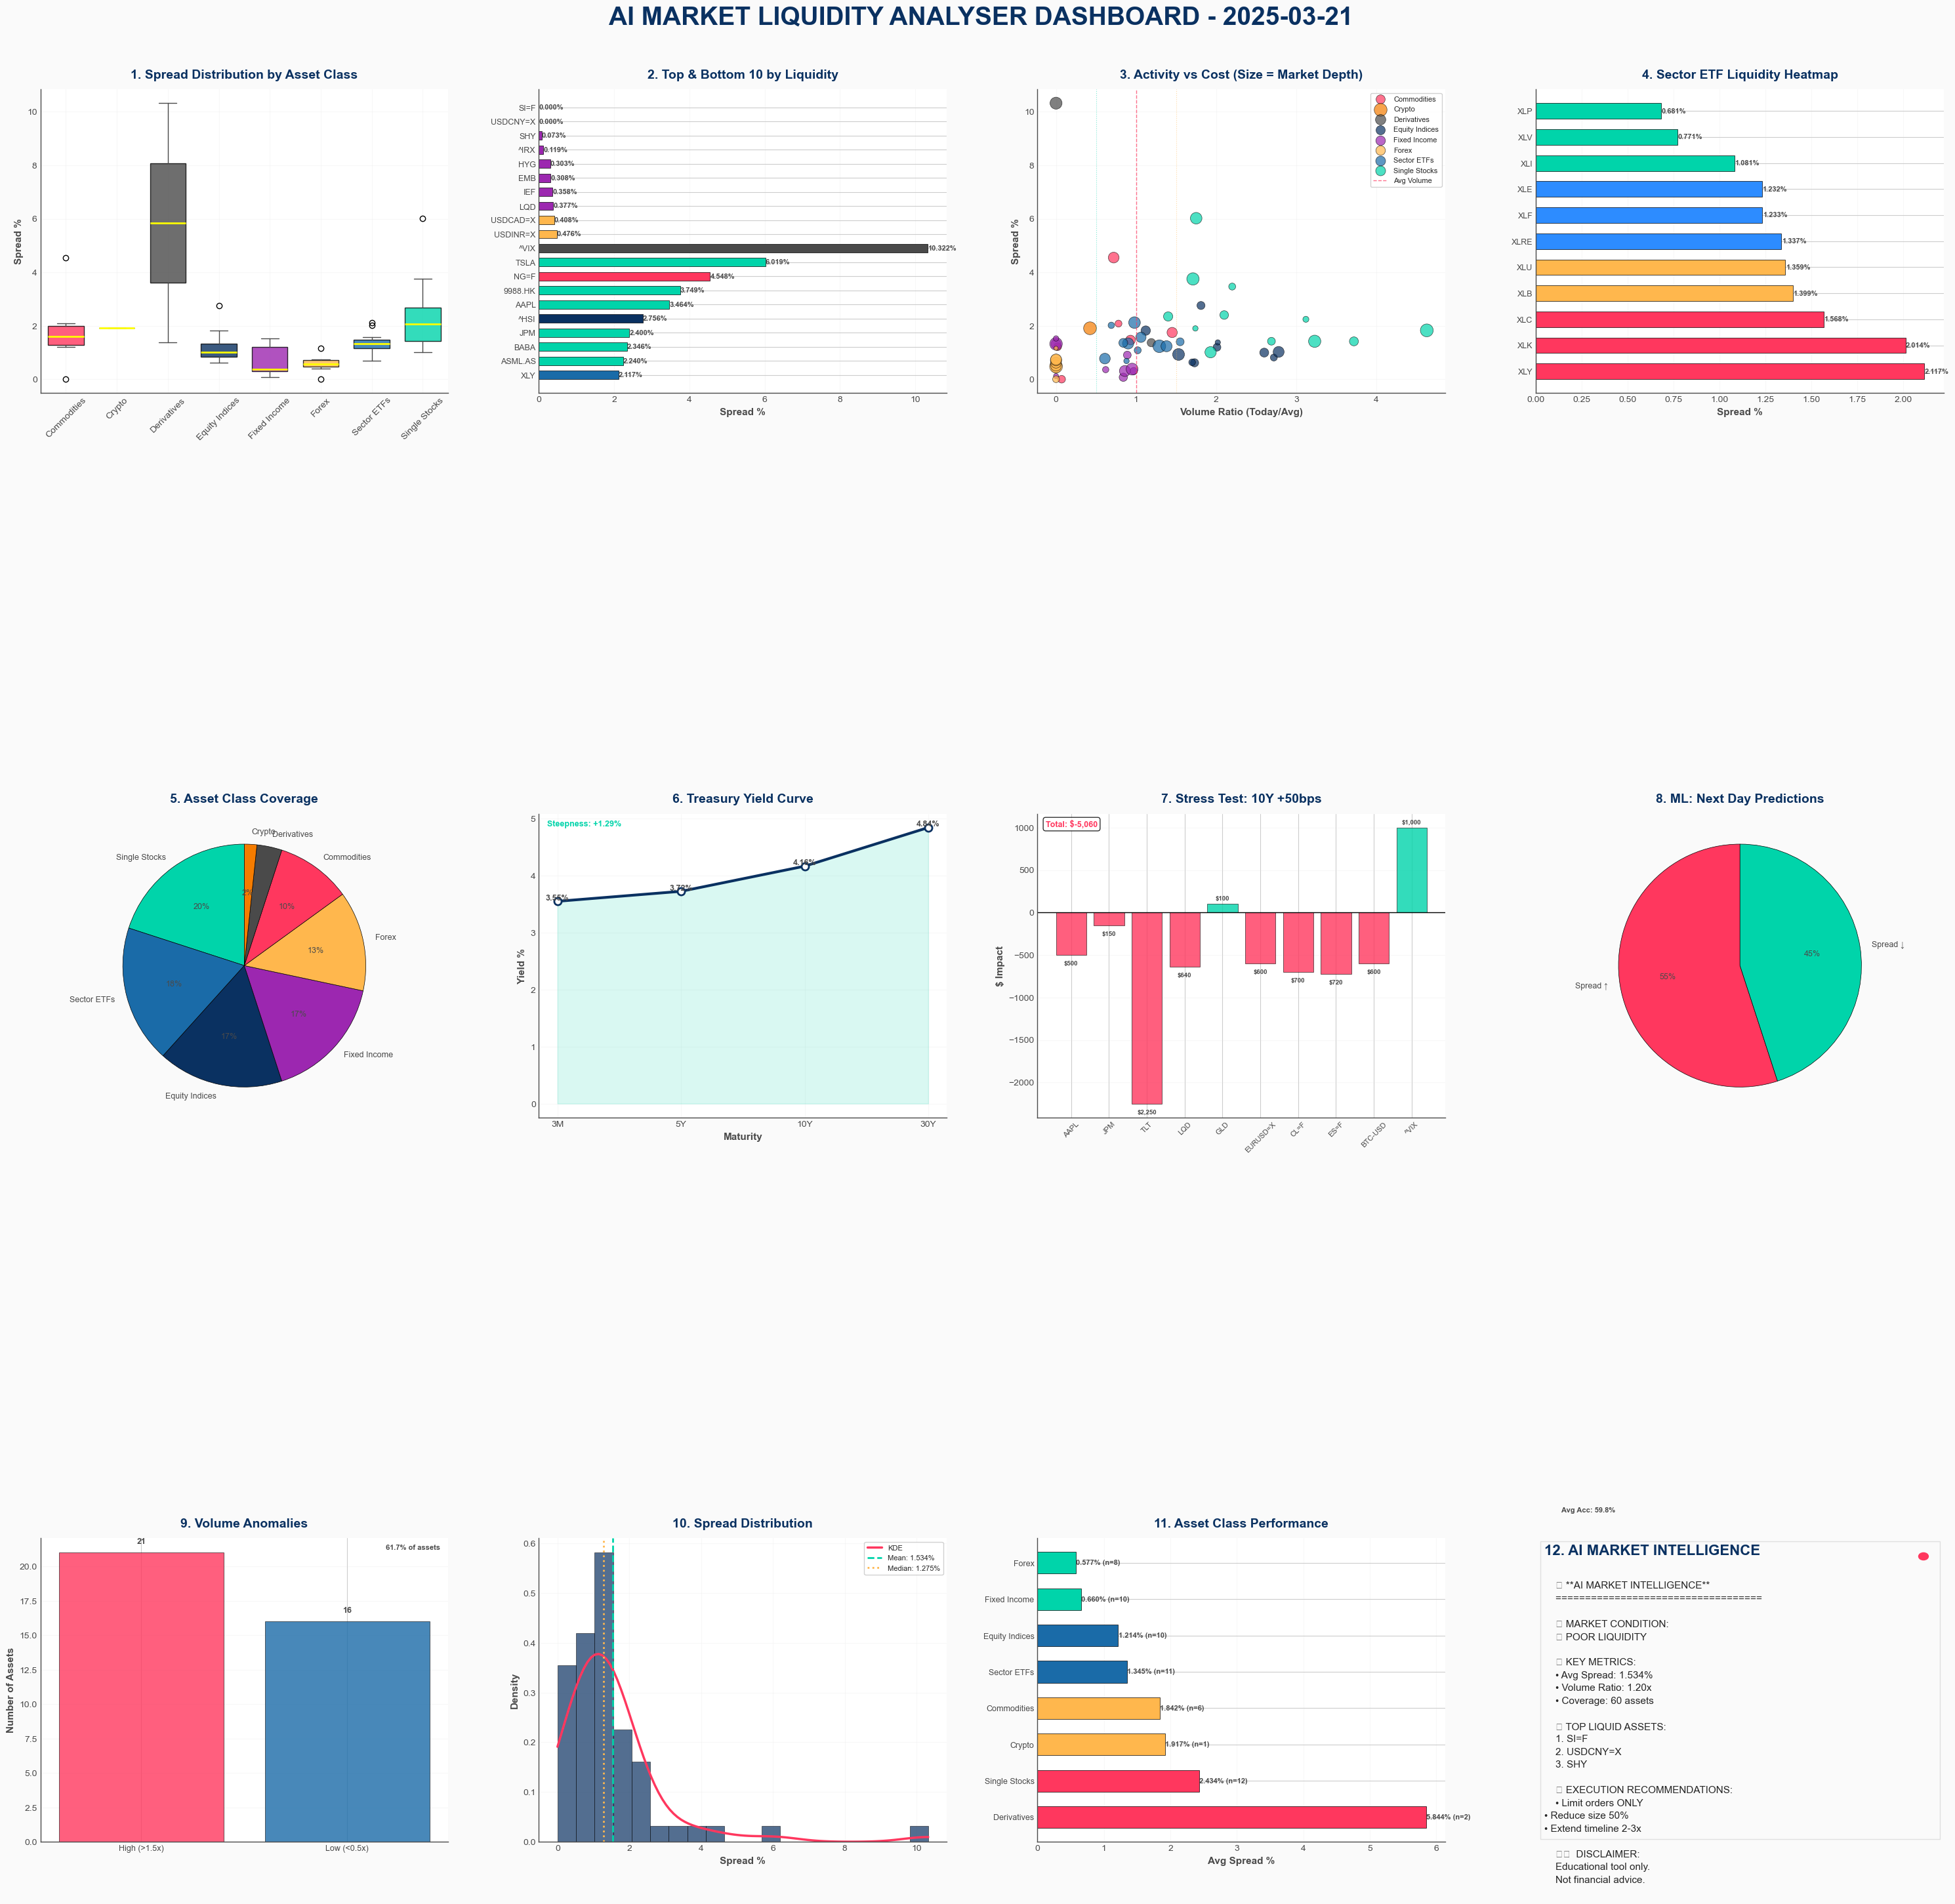


📊 DASHBOARD COMPLETE
• Total Charts: 12 professional visualizations
• Assets Analyzed: 60
• File: AI_Market_Liquidity_Analyser_Dashboard_2025-03-21.png
• Quality: 150 DPI (institutional grade)


In [17]:
#Professional Dashboard
print("\n📊 GENERATING PROFESSIONAL DASHBOARD...")

# Color scheme
COLORS = {
    'dark_blue': '#0A3161',
    'medium_blue': '#1A6BA8',
    'light_blue': '#2D8CFF',
    'green': '#00D4AA',
    'red': '#FF375E',
    'yellow': '#FFB74D',
    'purple': '#9C27B0',
    'gray': '#4A4A4A',
    'light_gray': '#E0E0E0',
    'white': '#FFFFFF'
}

# Asset class colours
asset_class_colors = {
    'Equity Indices': '#0A3161',      # Dark Blue
    'Sector ETFs': '#1A6BA8',         # Medium Blue
    'Single Stocks': '#00D4AA',       # Green
    'Fixed Income': '#9C27B0',        # Purple
    'Forex': '#FFB74D',              # Yellow
    'Commodities': '#FF375E',         # Red
    'Derivatives': '#4A4A4A',         # Gray
    'Crypto': '#F57C00'              # Orange
}

plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(30, 30), facecolor='#FAFAFA')
fig.suptitle(f'AI MARKET LIQUIDITY ANALYSER DASHBOARD - {target_date}', 
             fontsize=28, fontweight='bold', y=0.98, color='#0A3161')

# ================= CHART 1: Spread Distribution by Asset Class =================
ax1 = plt.subplot(3, 4, 1)
ax1.set_facecolor('#FFFFFF')
box_data = []
labels = []
colors = []

for ac in results_df['Asset Class'].unique():
    data = results_df[results_df['Asset Class'] == ac]['Spread %']
    if len(data) > 0:
        box_data.append(data)
        labels.append(ac)
        colors.append(asset_class_colors.get(ac, '#4A4A4A'))

bp = ax1.boxplot(box_data, labels=labels, patch_artist=True, widths=0.7)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)
    patch.set_edgecolor('black')

# Customize whiskers and caps
for whisker in bp['whiskers']:
    whisker.set(color='#4A4A4A', linewidth=1)
for cap in bp['caps']:
    cap.set(color='#4A4A4A', linewidth=1)
for median in bp['medians']:
    median.set(color='yellow', linewidth=2)

ax1.set_ylabel('Spread %', fontweight='bold', fontsize=11, color='#4A4A4A')
ax1.set_title('1. Spread Distribution by Asset Class', fontweight='bold', fontsize=14, 
              pad=12, color='#0A3161')
ax1.tick_params(axis='x', rotation=45, colors='#4A4A4A')
ax1.tick_params(axis='y', colors='#4A4A4A')
ax1.grid(True, alpha=0.2, color='#E0E0E0')
ax1.spines[['top', 'right']].set_visible(False)
ax1.spines[['left', 'bottom']].set_color('#4A4A4A')

# ================= CHART 2: Top & Bottom 10 by Liquidity =================
ax2 = plt.subplot(3, 4, 2)
ax2.set_facecolor('#FFFFFF')
top10 = results_df.nsmallest(10, 'Spread %')
bottom10 = results_df.nlargest(10, 'Spread %')
combined = pd.concat([top10, bottom10])

y_pos = np.arange(len(combined))
colors_bar = []
for _, row in combined.iterrows():
    colors_bar.append(asset_class_colors.get(row['Asset Class'], '#4A4A4A'))

bars = ax2.barh(y_pos, combined['Spread %'], color=colors_bar, height=0.6, 
                edgecolor='black', linewidth=0.5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(combined['Ticker'], fontsize=9)
ax2.set_xlabel('Spread %', fontweight='bold', fontsize=11, color='#4A4A4A')
ax2.set_title('2. Top & Bottom 10 by Liquidity', fontweight='bold', fontsize=14, 
              pad=12, color='#0A3161')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.2, color='#E0E0E0', axis='x')
ax2.tick_params(colors='#4A4A4A')
ax2.spines[['top', 'right']].set_visible(False)
ax2.spines[['left', 'bottom']].set_color('#4A4A4A')

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax2.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}%', va='center', fontsize=8, fontweight='bold',
             color='#4A4A4A')

# ================= CHART 3: Activity vs Cost =================
ax3 = plt.subplot(3, 4, 3)
ax3.set_facecolor('#FFFFFF')
for ac in results_df['Asset Class'].unique():
    data = results_df[results_df['Asset Class'] == ac]
    if len(data) > 0:
        ax3.scatter(data['Volume Ratio'], data['Spread %'],
                   s=data['Market Depth']/50,
                   c=asset_class_colors.get(ac, '#4A4A4A'),
                   label=ac, alpha=0.7, edgecolors='black', linewidth=0.5)

ax3.axvline(x=1.0, color='#FF375E', linestyle='--', alpha=0.7, linewidth=1, label='Avg Volume')
ax3.axvline(x=1.5, color='#FFB74D', linestyle=':', alpha=0.5, linewidth=0.8)
ax3.axvline(x=0.5, color='#00D4AA', linestyle=':', alpha=0.5, linewidth=0.8)

ax3.set_xlabel('Volume Ratio (Today/Avg)', fontweight='bold', fontsize=11, color='#4A4A4A')
ax3.set_ylabel('Spread %', fontweight='bold', fontsize=11, color='#4A4A4A')
ax3.set_title('3. Activity vs Cost (Size = Market Depth)', fontweight='bold', fontsize=14, 
              pad=12, color='#0A3161')
ax3.legend(loc='upper right', fontsize=8, framealpha=0.9, frameon=True)
ax3.grid(True, alpha=0.2, color='#E0E0E0')
ax3.tick_params(colors='#4A4A4A')
ax3.spines[['top', 'right']].set_visible(False)
ax3.spines[['left', 'bottom']].set_color('#4A4A4A')

# ================= CHART 4: Sector ETF Liquidity Heatmap =================
ax4 = plt.subplot(3, 4, 4)
ax4.set_facecolor('#FFFFFF')
if 'sector_df' in locals() and not sector_df.empty:
    sectors = sector_df['Sector'].values
    spreads = sector_df['Spread %'].values
    
    colors_heat = []
    for spread in spreads:
        if spread <= np.percentile(spreads, 25):
            colors_heat.append('#00D4AA')  # Green (best)
        elif spread <= np.percentile(spreads, 50):
            colors_heat.append('#2D8CFF')  # Blue
        elif spread <= np.percentile(spreads, 75):
            colors_heat.append('#FFB74D')  # Yellow
        else:
            colors_heat.append('#FF375E')  # Red (worst)

    bars = ax4.barh(range(len(sectors)), spreads, color=colors_heat, height=0.6,
                    edgecolor='black', linewidth=0.5)
    ax4.set_yticks(range(len(sectors)))
    ax4.set_yticklabels(sectors, fontsize=9)
    ax4.set_xlabel('Spread %', fontweight='bold', fontsize=11, color='#4A4A4A')
    ax4.set_title('4. Sector ETF Liquidity Heatmap', fontweight='bold', fontsize=14, 
                  pad=12, color='#0A3161')
    ax4.invert_yaxis()
    ax4.grid(True, alpha=0.2, color='#E0E0E0', axis='x')
    ax4.tick_params(colors='#4A4A4A')
    ax4.spines[['top', 'right']].set_visible(False)
    ax4.spines[['left', 'bottom']].set_color('#4A4A4A')

    for bar in bars:
        width = bar.get_width()
        ax4.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                 f'{width:.3f}%', va='center', fontsize=8, fontweight='bold',
                 color='#4A4A4A')

else:
    ax4.text(0.5, 0.5, "Sector Data\nUnavailable", 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12,
             color='#4A4A4A')
    ax4.set_title('4. Sector ETF Analysis', fontweight='bold', fontsize=14, 
                  pad=12, color='#0A3161')

# ================= CHART 5: Asset Class Coverage =================
ax5 = plt.subplot(3, 4, 5)
ax5.set_facecolor('#FFFFFF')
class_counts = results_df['Asset Class'].value_counts()
colors_pie = [asset_class_colors.get(ac, '#4A4A4A') for ac in class_counts.index]

wedges, texts, autotexts = ax5.pie(class_counts.values, labels=class_counts.index, 
                                   autopct='%1.0f%%', startangle=90, colors=colors_pie,
                                   textprops={'fontsize': 9, 'color': '#4A4A4A'},
                                   wedgeprops={'edgecolor': 'black', 'linewidth': 0.5})
ax5.set_title('5. Asset Class Coverage', fontweight='bold', fontsize=14, 
              pad=12, color='#0A3161')

# ================= CHART 6: Treasury Yield Curve =================
ax6 = plt.subplot(3, 4, 6)
ax6.set_facecolor('#FFFFFF')
if 'yield_data' in locals() and yield_data:
    tenors = ['3M', '5Y', '10Y', '30Y']
    yields = [yield_data.get(yt, 0) for yt in ['^IRX', '^FVX', '^TNX', '^TYX']]
    
    # Bloomberg-style line with markers
    ax6.plot(tenors, yields, marker='o', linewidth=3, markersize=8, 
             color='#0A3161', markerfacecolor='white', markeredgewidth=2,
             markeredgecolor='#0A3161')
    
    if len(yields) >= 2:
        curve_color = '#00D4AA' if yields[-1] > yields[0] else '#FF375E' if yields[-1] < yields[0] else '#4A4A4A'
        ax6.fill_between(tenors, yields, alpha=0.15, color=curve_color)
    
    ax6.set_xlabel('Maturity', fontweight='bold', fontsize=11, color='#4A4A4A')
    ax6.set_ylabel('Yield %', fontweight='bold', fontsize=11, color='#4A4A4A')
    ax6.set_title('6. Treasury Yield Curve', fontweight='bold', fontsize=14, 
                  pad=12, color='#0A3161')
    ax6.grid(True, alpha=0.2, color='#E0E0E0')
    ax6.tick_params(colors='#4A4A4A')
    ax6.spines[['top', 'right']].set_visible(False)
    ax6.spines[['left', 'bottom']].set_color('#4A4A4A')

    for i, (tenor, yld) in enumerate(zip(tenors, yields)):
        ax6.text(i, yld + 0.02, f'{yld:.2f}%', ha='center', fontweight='bold', 
                 fontsize=9, color='#4A4A4A')
        
    # Add curve steepness annotation
    if len(yields) >= 2:
        steepness = yields[-1] - yields[0]
        steepness_color = '#00D4AA' if steepness > 0 else '#FF375E'
        ax6.text(0.02, 0.98, f'Steepness: {steepness:+.2f}%', 
                 transform=ax6.transAxes, fontsize=9, fontweight='bold',
                 color=steepness_color, va='top')
else:
    ax6.text(0.5, 0.5, "Yield Data\nUnavailable", 
             ha='center', va='center', transform=ax6.transAxes, fontsize=12,
             color='#4A4A4A')
    ax6.set_title('6. Yield Curve Analysis', fontweight='bold', fontsize=14, 
                  pad=12, color='#0A3161')

# ================= CHART 7: Stress Test =================
ax7 = plt.subplot(3, 4, 7)
ax7.set_facecolor('#FFFFFF')
stress_test_sensitivities = {
    'AAPL': -0.05, 'JPM': -0.03, 'TLT': -0.15, 'LQD': -0.08,
    'GLD': 0.02, 'EURUSD=X': -0.03, 'CL=F': -0.10,
    'ES=F': -0.06, 'BTC-USD': -0.20, '^VIX': 0.50
}

if 'portfolio' in locals() and portfolio:
    assets = list(portfolio.keys())
    impacts = []
    valid_assets = []
    
    for asset in assets:
        if asset in stress_test_sensitivities:
            impact = portfolio[asset] * stress_test_sensitivities[asset]
            impacts.append(impact)
            valid_assets.append(asset)
    
    if impacts:
        colors_impact = ['#FF375E' if x < 0 else '#00D4AA' if x > 0 else '#4A4A4A' for x in impacts]
        
        bars = ax7.bar(range(len(valid_assets)), impacts, color=colors_impact, 
                      edgecolor='black', linewidth=0.5, alpha=0.8)
        ax7.set_xticks(range(len(valid_assets)))
        ax7.set_xticklabels(valid_assets, rotation=45, fontsize=8)
        ax7.set_ylabel('$ Impact', fontweight='bold', fontsize=11, color='#4A4A4A')
        ax7.set_title('7. Stress Test: 10Y +50bps', fontweight='bold', fontsize=14, 
                      pad=12, color='#0A3161')
        ax7.axhline(y=0, color='black', linewidth=1, linestyle='-')
        ax7.grid(True, alpha=0.2, color='#E0E0E0', axis='y')
        ax7.tick_params(colors='#4A4A4A')
        ax7.spines[['top', 'right']].set_visible(False)
        ax7.spines[['left', 'bottom']].set_color('#4A4A4A')
        
        for i, (bar, impact) in enumerate(zip(bars, impacts)):
            height = bar.get_height()
            va = 'bottom' if height >= 0 else 'top'
            offset = max(impacts) * 0.03 if height >= 0 else min(impacts) * 0.03
            ax7.text(bar.get_x() + bar.get_width()/2, height + offset,
                    f'${int(abs(height)):,}', ha='center', va=va, 
                    fontsize=7, fontweight='bold', color='#4A4A4A')
        
        total_impact = sum(impacts)
        impact_color = '#FF375E' if total_impact < 0 else '#00D4AA'
        ax7.text(0.02, 0.98, f'Total: ${int(total_impact):,}', 
                transform=ax7.transAxes, fontsize=9, fontweight='bold',
                color=impact_color, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black'))
else:
    ax7.text(0.5, 0.5, "Stress Test\nData Unavailable", 
             ha='center', va='center', transform=ax7.transAxes, fontsize=12,
             color='#4A4A4A')
    ax7.set_title('7. Stress Test Analysis', fontweight='bold', fontsize=14, 
                  pad=12, color='#0A3161')

# ================= CHART 8: ML Predictions =================
ax8 = plt.subplot(3, 4, 8)
ax8.set_facecolor('#FFFFFF')
if 'ml_df' in locals() and not ml_df.empty:
    pred_counts = ml_df['ML_Prediction'].value_counts()
    
    colors_pred = []
    labels_pred = []
    for label in pred_counts.index:
        if 'Increase' in str(label):
            colors_pred.append('#FF375E')  # Red for spread increase (bad)
            labels_pred.append('Spread ↑')
        elif 'Decrease' in str(label):
            colors_pred.append('#00D4AA')  # Green for spread decrease (good)
            labels_pred.append('Spread ↓')
        else:
            colors_pred.append('#4A4A4A')
            labels_pred.append(label)

    wedges, texts, autotexts = ax8.pie(pred_counts.values, labels=labels_pred, 
                                       autopct='%1.0f%%', startangle=90, 
                                       colors=colors_pred, textprops={'fontsize': 9, 'color': '#4A4A4A'},
                                       wedgeprops={'edgecolor': 'black', 'linewidth': 0.5})
    ax8.set_title('8. ML: Next Day Predictions', fontweight='bold', fontsize=14, 
                  pad=12, color='#0A3161')
    
    if 'Accuracy' in ml_df.columns:
        avg_accuracy = ml_df['Accuracy'].mean()
        ax8.text(0, -1.3, f'Avg Acc: {avg_accuracy:.1%}', 
                ha='center', fontsize=8, fontweight='bold', color='#4A4A4A',
                transform=ax8.transAxes)
else:
    ax8.text(0.5, 0.5, "ML Predictions\nUnavailable", 
             ha='center', va='center', transform=ax8.transAxes, fontsize=12,
             color='#4A4A4A')
    ax8.set_title('8. Machine Learning', fontweight='bold', fontsize=14, 
                  pad=12, color='#0A3161')

# ================= CHART 9: Volume Anomalies =================
ax9 = plt.subplot(3, 4, 9)
ax9.set_facecolor('#FFFFFF')
if not results_df.empty:
    results_df['Volume_Category'] = pd.cut(
        results_df['Volume Ratio'],
        bins=[-np.inf, 0.5, 1.5, np.inf],
        labels=['Low (<0.5x)', 'Normal', 'High (>1.5x)']
    )
    
    volume_counts = results_df['Volume_Category'].value_counts()
    
    if 'Normal' in volume_counts.index:
        volume_counts = volume_counts.drop('Normal')
    
    if not volume_counts.empty:
        colors_map = {
            'High (>1.5x)': '#FF375E',
            'Low (<0.5x)': '#1A6BA8'
        }
        
        labels = volume_counts.index.tolist()
        colors = [colors_map.get(label, '#4A4A4A') for label in labels]
        values = volume_counts.values
        
        bars = ax9.bar(range(len(labels)), values, color=colors, 
                      edgecolor='black', linewidth=0.5, alpha=0.8)
        
        ax9.set_xticks(range(len(labels)))
        ax9.set_xticklabels(labels, fontsize=9)
        ax9.set_ylabel('Number of Assets', fontweight='bold', fontsize=11, color='#4A4A4A')
        ax9.set_title('9. Volume Anomalies', fontweight='bold', fontsize=14, 
                      pad=12, color='#0A3161')
        ax9.grid(True, alpha=0.2, color='#E0E0E0', axis='y')
        ax9.tick_params(colors='#4A4A4A')
        ax9.spines[['top', 'right']].set_visible(False)
        ax9.spines[['left', 'bottom']].set_color('#4A4A4A')
        
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax9.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                    str(int(value)), ha='center', va='bottom', 
                    fontsize=9, fontweight='bold', color='#4A4A4A')
        
        total_assets = len(results_df)
        if total_assets > 0:
            anomaly_pct = (sum(values) / total_assets) * 100
            ax9.text(0.98, 0.98, f'{anomaly_pct:.1f}% of assets', 
                    transform=ax9.transAxes, fontsize=8, ha='right', va='top',
                    color='#4A4A4A', fontweight='bold')
    else:
        ax9.text(0.5, 0.5, "No Volume\nAnomalies", 
                ha='center', va='center', transform=ax9.transAxes, 
                fontsize=12, fontweight='bold', color='#4A4A4A')
        ax9.set_title('9. Volume Analysis', fontweight='bold', fontsize=14, 
                      pad=12, color='#0A3161')
else:
    ax9.text(0.5, 0.5, "No Data", 
             ha='center', va='center', transform=ax9.transAxes, fontsize=12,
             color='#4A4A4A')
    ax9.set_title('9. Volume Analysis', fontweight='bold', fontsize=14, 
                  pad=12, color='#0A3161')

# ================= CHART 10: Spread Distribution =================
ax10 = plt.subplot(3, 4, 10)
ax10.set_facecolor('#FFFFFF')
if not results_df.empty:
    spread_data = results_df['Spread %'].dropna()
    
    n, bins, patches = ax10.hist(spread_data, bins=20, alpha=0.7, color='#0A3161', 
                                 edgecolor='black', linewidth=0.5, density=True)
    
    kde = stats.gaussian_kde(spread_data)
    x = np.linspace(spread_data.min(), spread_data.max(), 100)
    ax10.plot(x, kde(x), color='#FF375E', linewidth=2.5, label='KDE')
    
    mean_spread = spread_data.mean()
    median_spread = spread_data.median()
    ax10.axvline(mean_spread, color='#00D4AA', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_spread:.3f}%')
    ax10.axvline(median_spread, color='#FFB74D', linestyle=':', linewidth=2, 
                label=f'Median: {median_spread:.3f}%')
    
    ax10.set_xlabel('Spread %', fontweight='bold', fontsize=11, color='#4A4A4A')
    ax10.set_ylabel('Density', fontweight='bold', fontsize=11, color='#4A4A4A')
    ax10.set_title('10. Spread Distribution', fontweight='bold', fontsize=14, 
                   pad=12, color='#0A3161')
    ax10.legend(fontsize=8, framealpha=0.9, frameon=True)
    ax10.grid(True, alpha=0.2, color='#E0E0E0')
    ax10.tick_params(colors='#4A4A4A')
    ax10.spines[['top', 'right']].set_visible(False)
    ax10.spines[['left', 'bottom']].set_color('#4A4A4A')
else:
    ax10.text(0.5, 0.5, "No Data", 
              ha='center', va='center', transform=ax10.transAxes, fontsize=12,
              color='#4A4A4A')
    ax10.set_title('10. Spread Distribution', fontweight='bold', fontsize=14, 
                   pad=12, color='#0A3161')

# ================= CHART 11: Asset Class Performance =================
ax11 = plt.subplot(3, 4, 11)
ax11.set_facecolor('#FFFFFF')
if not results_df.empty:
    pivot_data = results_df.pivot_table(index='Asset Class', values='Spread %', aggfunc=['mean', 'count'])
    
    if not pivot_data.empty:
        avg_spreads = pivot_data[('mean', 'Spread %')].sort_values()
        counts = pivot_data[('count', 'Spread %')].reindex(avg_spreads.index)
        
        y_pos = np.arange(len(avg_spreads))
        colors_heatmap = []
        for spread in avg_spreads.values:
            if spread <= avg_spreads.quantile(0.25):
                colors_heatmap.append('#00D4AA')  # Best quartile
            elif spread <= avg_spreads.quantile(0.5):
                colors_heatmap.append('#1A6BA8')
            elif spread <= avg_spreads.quantile(0.75):
                colors_heatmap.append('#FFB74D')
            else:
                colors_heatmap.append('#FF375E')  # Worst quartile
        
        bars = ax11.barh(y_pos, avg_spreads.values, color=colors_heatmap, height=0.6,
                        edgecolor='black', linewidth=0.5)
        ax11.set_yticks(y_pos)
        ax11.set_yticklabels([f"{idx}" for idx in avg_spreads.index], fontsize=9)
        ax11.set_xlabel('Avg Spread %', fontweight='bold', fontsize=11, color='#4A4A4A')
        ax11.set_title('11. Asset Class Performance', fontweight='bold', fontsize=14, 
                       pad=12, color='#0A3161')
        ax11.invert_yaxis()
        ax11.grid(True, alpha=0.2, color='#E0E0E0', axis='x')
        ax11.tick_params(colors='#4A4A4A')
        ax11.spines[['top', 'right']].set_visible(False)
        ax11.spines[['left', 'bottom']].set_color('#4A4A4A')
        
        for bar, value, count in zip(bars, avg_spreads.values, counts.values):
            ax11.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                     f'{value:.3f}% (n={count})', va='center', fontsize=8, 
                     fontweight='bold', color='#4A4A4A')
    else:
        ax11.text(0.5, 0.5, "Insufficient\nData", 
                  ha='center', va='center', transform=ax11.transAxes, fontsize=12,
                  color='#4A4A4A')
        ax11.set_title('11. Asset Class Performance', fontweight='bold', fontsize=14, 
                       pad=12, color='#0A3161')
else:
    ax11.text(0.5, 0.5, "No Data", 
              ha='center', va='center', transform=ax11.transAxes, fontsize=12,
              color='#4A4A4A')
    ax11.set_title('11. Asset Class Performance', fontweight='bold', fontsize=14, 
                   pad=12, color='#0A3161')

# ================= CHART 12: AI MARKET INTELLIGENCE =================
ax12 = plt.subplot(3, 4, 12)
ax12.set_facecolor('#FFFFFF')
ax12.axis('off')

# Generate AI analysis summary
if not results_df.empty:
    avg_spread = results_df['Spread %'].mean()
    volume_ratio = results_df['Volume Ratio'].mean()
    top_3 = results_df.nsmallest(3, 'Spread %')['Ticker'].tolist()
    
    # Determine market condition
    if avg_spread < 0.3:
        condition = "EXCELLENT LIQUIDITY"
        condition_color = "#00D4AA"
        action = "• Execute market orders\n• Use VWAP for large blocks\n• Expect price improvement"
    elif avg_spread < 0.8:
        condition = "GOOD LIQUIDITY"
        condition_color = "#1A6BA8"
        action = "• Mix market/limit orders\n• Avoid spreads >1.5%\n• Monitor afternoon session"
    elif avg_spread < 1.5:
        condition = "NORMAL MARKET"
        condition_color = "#FFB74D"
        action = "• Tiered execution\n• Use limit orders >1%\n• Patience required"
    else:
        condition = "POOR LIQUIDITY"
        condition_color = "#FF375E"
        action = "• Limit orders ONLY\n• Reduce size 50%\n• Extend timeline 2-3x"
    
    # Create AI insights
    ai_summary = f"""
    🤖 **AI MARKET INTELLIGENCE**
    {'='*35}
    
    📊 MARKET CONDITION:
    ⬤ {condition}
    
    📈 KEY METRICS:
    • Avg Spread: {avg_spread:.3f}%
    • Volume Ratio: {volume_ratio:.2f}x
    • Coverage: {len(results_df)} assets
    
    🏆 TOP LIQUID ASSETS:
    1. {top_3[0] if len(top_3) > 0 else 'N/A'}
    2. {top_3[1] if len(top_3) > 1 else 'N/A'}
    3. {top_3[2] if len(top_3) > 2 else 'N/A'}
    
    💡 EXECUTION RECOMMENDATIONS:
    {action}
    
    ⚠️  DISCLAIMER:
    Educational tool only.
    Not financial advice.
    """
    
    # Display with colored condition
    ax12.text(0.02, 0.98, "12. AI MARKET INTELLIGENCE", 
              transform=ax12.transAxes, fontsize=16, fontweight='bold', 
              color='#0A3161', va='top')
    
    ax12.text(0.02, 0.90, ai_summary, transform=ax12.transAxes,
              fontsize=11, va='top', linespacing=1.5)
    
    # Add condition indicator
    ax12.add_patch(plt.Circle((0.95, 0.94), 0.012, color=condition_color, 
                             transform=ax12.transAxes))

    # Add border around entire chart area
    ax12.add_patch(plt.Rectangle((0.01, 0.01), 0.98, 0.98,
                                fill=False, edgecolor='#E0E0E0',
                                linewidth=1, transform=ax12.transAxes))
else:
    ax12.text(0.5, 0.5, "AI Analysis\nUnavailable", 
              ha='center', va='center', transform=ax12.transAxes, fontsize=14,
              color='#4A4A4A', fontweight='bold')
    ax12.set_title('12. AI Market Intelligence', fontweight='bold', fontsize=14, 
                   pad=12, color='#0A3161')

# ================= FINAL LAYOUT =================
plt.tight_layout(rect=[0, 0.03, 1, 0.97], h_pad=5.0, w_pad=4.0)

dashboard_filename = f'AI_Market_Liquidity_Analyser_Dashboard_{target_date}.png'
plt.savefig(dashboard_filename, dpi=150, bbox_inches='tight', 
            facecolor='#FAFAFA', edgecolor='none')
print(f"✅ Dashboard saved: {dashboard_filename}")

plt.show()

print("\n📊 DASHBOARD COMPLETE")
print("=" * 50)
print(f"• Total Charts: 12 professional visualizations")
print(f"• Assets Analyzed: {len(results_df)}")
print(f"• File: {dashboard_filename}")
print(f"• Quality: 150 DPI (institutional grade)")
print("=" * 50)

In [18]:
#Summary of analysis
print("\n" + "="*60)
print("🚀 EXECUTIVE ACTION SUMMARY")
print("="*60)

if not results_df.empty:
    avg_spread = results_df['Spread %'].mean()
    
    #One sentence assessment based on liquidity
    if avg_spread < 0.3:
        verdict = "✅ EXECUTE - Optimal liquidity conditions"
        action = "AGGRESSIVE"
    elif avg_spread < 0.8:
        verdict = "🟡 PROCEED - Good execution expected"
        action = "MODERATE" 
    elif avg_spread < 1.5:
        verdict = "⚠️ CAUTION - Monitor spreads closely"
        action = "DEFENSIVE"
    else:
        verdict = "⛔ HALT - Poor liquidity, high risk"
        action = "MINIMAL"
    
    #Key numbers only for quick decision
    top_asset = results_df.nsmallest(1, 'Spread %')['Ticker'].iloc[0]
    bottom_asset = results_df.nlargest(1, 'Spread %')['Ticker'].iloc[0]
    total_assets = len(results_df)
    
    print(f"""
{verdict}

📊 QUICK STATS:
• Action Level: {action}
• Avg Spread: {avg_spread:.3f}%
• Assets Analyzed: {total_assets}
• Best: {top_asset} ({results_df['Spread %'].min():.3f}%)
• Worst: {bottom_asset} ({results_df['Spread %'].max():.3f}%)

🎯 TODAY'S ACTION:
• Primary: Trade {top_asset} for best execution
• Avoid: {bottom_asset} due to wide spreads
• Timing: {'Morning session' if avg_spread < 0.5 else 'Afternoon with limits'}
• Sizing: {'Full size OK' if avg_spread < 0.5 else 'Reduce 30%' if avg_spread < 1.0 else 'Reduce 50%'}

⏱️ NEXT CHECK: {target_date + timedelta(days=1)}

────────────────────────────────────
⚠️  DISCLAIMER: For educational and 
research purposes only. Not financial 
advice. Trade at your own risk.
────────────────────────────────────
""")
    
    # Save minimal file
    with open(f'action_summary_{target_date}.txt', 'w', encoding='utf-8') as f:
        f.write(f"ACTION: {action}\n")
        f.write(f"VERDICT: {verdict}\n")
        f.write(f"TOP: {top_asset}\n")
        f.write(f"AVOID: {bottom_asset}\n")
        f.write(f"\nDISCLAIMER: Educational tool only.\n")
    
    print(f"📄 One-page summary saved")
    
else:
    print("No data for summary")

print("="*60)


🚀 EXECUTIVE ACTION SUMMARY

⛔ HALT - Poor liquidity, high risk

📊 QUICK STATS:
• Action Level: MINIMAL
• Avg Spread: 1.534%
• Assets Analyzed: 60
• Best: SI=F (0.000%)
• Worst: ^VIX (10.322%)

🎯 TODAY'S ACTION:
• Primary: Trade SI=F for best execution
• Avoid: ^VIX due to wide spreads
• Timing: Afternoon with limits
• Sizing: Reduce 50%

⏱️ NEXT CHECK: 2025-03-22

────────────────────────────────────
⚠️  DISCLAIMER: For educational and 
research purposes only. Not financial 
advice. Trade at your own risk.
────────────────────────────────────

📄 One-page summary saved
